# Predicting Bike Rentals

In [1]:
#importing various packages
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#suppress displaying long numbers in scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [2]:
#read in the data
bike_rentals = pd.read_csv('bike_rental_hour.csv')

print(bike_rentals.head())

#cnt is the total number of bike rentals, casual + registered

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp  atemp  hum  windspeed  casual  registered  cnt  
0           1  0.24   0.29 0.81       0.00       3          13   16  
1           1  0.22   0.27 0.80       0.00       8          32   40  
2           1  0.22   0.27 0.80       0.00       5          27   32  
3           1  0.24   0.29 0.75       0.00       3          10   13  
4           1  0.24   0.29 0.75       0.00       0           1    1  


## Correlations

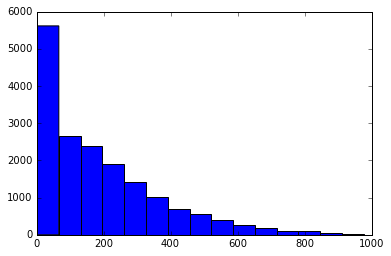

In [3]:
#produce a histogram of the cnt column to show distribution of total rentals
plt.hist(bike_rentals.cnt, bins=15)
plt.show()

In [4]:
#compute pairwise correlations for each column in bike_rentals
full_corrs = bike_rentals.corr()

# see how every other column is correlated with cnt
cnt_corr = full_corrs['cnt'].sort_values(ascending=False)
print(cnt_corr)

cnt           1.00
registered    0.97
casual        0.69
temp          0.40
atemp         0.40
hr            0.39
instant       0.28
yr            0.25
season        0.18
mnth          0.12
windspeed     0.09
workingday    0.03
weekday       0.03
holiday      -0.03
weathersit   -0.14
hum          -0.32
Name: cnt, dtype: float64


## Calculating Features

In [5]:
#calculating features can enhance the accuracy of the models 
#by introducing new information

#function that takes in a numeric value for hour and assigns a label
#based on the hour; '1' if 6-12, '2' if 12-18, '3' if 18-24, '4' if 0-6
def assign_label(hr):
    
    if hr >= 6 and hr < 12:
        return 1
    elif hr >= 12 and hr < 18: 
        return 2
    elif hr >= 18 and hr < 24: 
        return 3
    elif hr >= 0 and hr < 6:
        return 4
    else:
        return math.nan

#applying the function to time_label 
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

#understanding how many rows correspond to each label
print(bike_rentals['time_label'].value_counts())


2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64


## Error Metric

Let's use mean squared error to evaluate error in the models. MSE works on continuous numeric data, which is applicable to our target variable, cnt. 

## Splitting Data into Train and Test Sets

In [6]:
#use the dataframe.sample method to select 80% of the rows for training
train = bike_rentals.sample(frac=0.8, replace=False)
#select rows in bike_rentals that aren't found in train and assign to test set
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [7]:
#finding features, or predictor columns
predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")
#predictors.remove("windspeed")
#predictors.remove("workingday")
#predictors.remove("weekday")
#predictors.remove("holiday")

print(predictors)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


## Linear Regression

In [8]:
#instantiate linear Regresssion object
lr = LinearRegression(fit_intercept=True, normalize=False)

#fit model to training data
lr.fit(train[predictors], train['cnt'])

#make predictions on test data
predictions = lr.predict(test[predictors])

#error
mse = mean_squared_error(test.cnt, predictions)
rmse = np.sqrt(mse)
print("RMSE: " + str(rmse) + '\n')

lr_bike_rentals = test.copy()
lr_bike_rentals['lr_cnt'] = predictions
print(lr_bike_rentals[['cnt','lr_cnt']].head(10))

RMSE: 131.29500896572577

    cnt  lr_cnt
0    16 -112.31
5     1  -85.88
9    14  115.59
15  110  129.07
19   37   74.43
23   39  121.83
24   17  -87.27
28    3  -72.08
33   53   99.04
35   93   87.17


The error with this linear regression model is very high. This is due to the actual rental totals being relatively low, with random high spikes in rental counts. MSE penalizes large errors and thus contributes to a higher total error. 

## Decision Trees

In [30]:
treereg = DecisionTreeRegressor(max_depth=100, min_samples_split=40, min_samples_leaf=2)

#fit model to train data
treereg.fit(train[predictors], train['cnt'])

#make predictions on test data 
predictions = treereg.predict(test[predictors])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)

print("RMSE: " + str(rmse) + '\n')

RMSE: 49.793759016418775



Decision Trees prove to have much higher accuracy than the Linear Regression model. 

## Random Forest

In [56]:
#n_estimators is the number of trees in the forest
foreg = RandomForestRegressor(n_estimators= 30, random_state=1, bootstrap=True, max_depth=50, min_samples_split=5, min_samples_leaf=2)

#fit model to train data
foreg.fit(train[predictors], train['cnt'])

#make predictions on test data 
predictions = foreg.predict(test[predictors])

mse = mean_squared_error(test['cnt'], predictions)
rmse = np.sqrt(mse)

print("RMSE: " + str(rmse) + '\n')

RMSE: 40.96032585041487



Random Forest improves on Decision Trees, as shown by the marked improvement in RMSE value. They are less prone to overfitting as well. 